In [1]:
#!python3 extract_data.py '9'
#!python3 extract_data.py '10'
#!python3 extract_data.py '11'
#!python3 extract_data.py '12'

In [2]:
#!python train_neural_model.py 9

In [3]:
#!python train_neural_model.py '9'
#!CUDA_VISIBLE_DEVICES=0 python3 train_neural_model.py '10'
#!CUDA_VISIBLE_DEVICES=0 python3 train_neural_model.py '11'
#!CUDA_VISIBLE_DEVICES=0 python3 train_neural_model.py '12'

In [4]:
import torch
import torchvision.models as models 
import torchvision.transforms.functional as F
from torchvision import datasets, transforms

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1, util, inceptionv1_avgPool

import numpy as np
import pickle
import h5py
from scipy.io import savemat
from pathlib import Path
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import shapely.affinity
import shapely.geometry
from skimage.draw import polygon
from skimage.morphology import convex_hull_image
from skimage.filters import gaussian as smoothing
from helper import gaussian, moments, fitgaussian, load
from PIL import Image  

from neural_model import Model

c:\Users\lopez\Anaconda3\envs\test_install_cuda_with_pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
seed = 0
pixperdeg = 12
stim_size = 500
mask_size = 128
shift_x = 100
shift_y = 100
#roi_names = ['1','2','3','4','5','7','8','9','10','11','12','13','14','15','16']

#roi_names = ['9']
roi_names = ['9', '10', '11', '12']

In [3]:
def load_trained_model(roi_name,layer=False):
    if not layer:
        data_filename = 'E:/Jose/snapshots/grid_search_array'+ roi_name +'.pkl'
        f = open(data_filename,"rb")
        cc = pickle.load(f)
        val_corrs = cc['val_corrs']
        params = cc['params']
        val_corrs = np.array(val_corrs)
        layer = params[np.where(val_corrs==val_corrs.max())[0][0].astype('int')][0]
    data_filename      = 'E:/Jose/Data/data_THINGS_array'+ roi_name +'_v1.pkl'
    #data_filename = '/media/stijn/2bb74e85-3681-4561-88b7-abd98482de61/paolo/Data/data_THINGS_array'+ roi_name +'_v1.pkl'
    f = open(data_filename,"rb")
    cc = pickle.load(f)
    val_data = cc['val_data']
    del cc
    
    n_neurons = val_data.shape[1]

    pretrained_model = inceptionv1(pretrained=True)
    roi_model = Model(pretrained_model,layer,n_neurons,device='cpu')
    snapshot_path = f'E:/Jose/snapshots/array'+ roi_name +'_neural_model.pt'
    roi_model.load_state_dict(torch.load(snapshot_path,map_location=torch.device('cpu')))
    return roi_model,n_neurons

def compute_val_corrs(roi_name,roi_model):
    data_filename      = 'E:/Jose/Data/data_THINGS_array'+ roi_name +'_v1.pkl'
    #data_filename = '/media/stijn/2bb74e85-3681-4561-88b7-abd98482de61/paolo/Data/data_THINGS_array'+ roi_name +'_v1.pkl'
    f = open(data_filename,"rb")
    cc = pickle.load(f)

    val_img_data = cc['val_img_data']
    val_outputs = roi_model(val_img_data).squeeze()
    val_data = cc['val_data']
    del cc
    
    corrs = []
    for n in range(val_outputs.shape[1]):
        corrs.append(np.corrcoef(val_outputs[:,n].cpu().detach().numpy(),val_data[:,n])[1,0])
    return corrs

def good_neurons(roi_model,n_neurons,corrs,display=False):
    all_good_rfs = []
    goods = []
    for n in range(n_neurons):
        roi_model_rf = np.abs(np.reshape(roi_model.w_s[n].squeeze().detach().cpu().numpy(),
                          [np.sqrt(roi_model.w_s.shape[2]).astype('int'),np.sqrt(roi_model.w_s.shape[2]).astype('int')]))
        
        if int(roi_name) < 9: #V1
            conds = corrs[n] > 0 and np.std(roi_model_rf)/roi_model_rf.max() < 0.12
        elif int(roi_name) > 12: #IT
            conds = corrs[n] > 0
        else: #V4
            conds = corrs[n] > 0 and np.std(roi_model_rf)/roi_model_rf.max() < 0.3
            
        if conds:
            print(n,corrs[n])
            goods.append(n)
            roi_model_rf_norm = (roi_model_rf+np.abs(roi_model_rf.min()))/(np.abs(roi_model_rf.max())+np.abs(roi_model_rf.min()))
            all_good_rfs.append(roi_model_rf_norm)
            if display:
                plt.imshow(roi_model_rf, cmap='seismic')
                plt.colorbar()
                plt.show()
                plt.plot(roi_model.w_f[0,n].squeeze().detach().cpu().numpy())
                plt.show()

    goods = np.array(goods)
    all_good_rfs = np.array(all_good_rfs)
    return goods,all_good_rfs

def gaussian_RFs(all_good_rfs,goods,corrs,pixperdeg,stim_size,roi_name,shift_x,shift_y):
    centrex = []
    centrey = []
    szx = []
    szy = []
    szdeg = []

    pixperdeg_reduced = all_good_rfs[0].shape[0]/all_good_rfs*pixperdeg
    scaling_f = stim_size/all_good_rfs[0].shape[0]
    fovea_x = stim_size/2 - shift_x
    fovea_y = stim_size/2 - shift_y
    ax = plt.gca()
    for n in range(len(goods)):

        # fit 2d Gaussian to W_s
        data = all_good_rfs[n]
        params = fitgaussian(data)
        (height, y, x, width_y, width_x) = params # x and y are shifted in img coords

        x = x*scaling_f-fovea_x
        y = -(y*scaling_f-fovea_y)
        szx_temp = 2*width_x*scaling_f
        szy_temp = 2*width_y*scaling_f
        
        circle = Ellipse((x, y), 2*szx_temp, 2*szy_temp, edgecolor='r', facecolor='None', clip_on=True)
        ax.add_patch(circle)
        plt.scatter(x,y)
        # save the estimated 2d Gaussians (diameter = 95% CI)
        centrex.append(x)
        centrey.append(y)
        szx.append(szx_temp)
        szy.append(szy_temp)
        szdeg.append(np.mean((2*width_x/pixperdeg_reduced,2*width_y/pixperdeg_reduced)))
    
    plt.xlim([-150, 350])    
    plt.ylim([-350, 150])
    plt.scatter(0,0)
    ax.axis('equal')
    plt.show()
    centrex = np.array(centrex)
    centrey = np.array(centrey)
    szx = np.array(szx)
    szy = np.array(szy)
    szdeg = np.array(szdeg)

    output = {'goods':goods,
             'all_good_rfs':all_good_rfs,
             'cross_val_corr':corrs,
             'centrex':centrex,
             'centrey':centrey,
             'szx':szx,
             'szy':szy,
             'szdeg':szdeg,}
    savemat('Data/array' + roi_name + '_good_rfs' + '.mat', output)

def generate_MEIS(roi_model,roi_name,goods):
    Path('E:/Jose/MEIs/array' + roi_name + '_fft_decorr_lr_1e-2_l2_1e-4/').mkdir(parents=True, exist_ok=True)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    roi_model.to(device).eval()
    all_transforms = [
        #transform.pad(2),
        transform.jitter(8),
        transform.random_scale([n/1000. for n in range(975, 1050)]),
        transform.random_rotate(list(range(-5,5))),
        transform.jitter(4)
   ]
    batch_param_f = lambda: param.image(128, batch=5, fft=True, decorrelate=True)
    cppn_opt = lambda params: torch.optim.Adam(params, 1e-2, weight_decay=1e-4)

    for chn in range(len(goods)):
        obj = objectives.channel("output", int(goods[chn]))
        _ = render.render_vis(roi_model, obj, batch_param_f, cppn_opt, transforms=all_transforms, 
                              show_inline=True, thresholds=(50,))
        for n in range(_[0].shape[0]):
            #filename = 'MEIs/array' + roi_name + '_fft_decorr_lr_1e-2_l2_1e-4/' + str(chn) + '_' + str(n) + '.bmp'
            temp = _[0][n]
            temp_pic = Image.fromarray(np.uint8((temp)*255))
            temp_pic = temp_pic.resize((500,500),Image.BILINEAR)
            #temp_pic.save(filename)
            np_pic = np.array(temp_pic)
            plt.imsave('E:/Jose/MEIs/array' + roi_name + '_fft_decorr_lr_1e-2_l2_1e-4/' + str(chn) + '_' + str(n) + '.bmp', np_pic)

Roi name:   9 


1/5.  Start point 0
mixed4a
CatLayer()
2/5. Loaded 37
3/5. Corrd 86
0 0.6604398152808468
1 0.7008303940488678
2 0.7871289749742397
3 0.6867284886526439
4 0.8044855658693628
5 0.6023363033148091
6 0.49286223738997303
7 0.6222693208489063
8 0.7946225876665013
9 0.7308213591077553
10 0.6492809325154507
11 0.7878816433096583
12 0.7583164474979706
13 0.7107704186523995
14 0.7673202358546912
15 0.7929018666873753
16 0.7796309994059023
17 0.6903605223622751
18 0.8138586908406598
19 0.7350441597425873
20 0.68883217997248
21 0.45652838297759935
22 0.789932350075189
23 0.7373885738558045
24 0.6368267934771488
25 0.7223341633802516
26 0.5608816006776823
27 0.7336405916948755
28 0.7599206592624688
29 0.7294666290618796
30 0.6704183028734707
31 0.6303908850926071
32 0.6101727305473514
33 0.72825164916909
34 0.7776551010189743
35 0.5553693750996915
36 0.6201796581179048
37 0.4923808691960794
38 0.7035261261194277
39 0.6618021582552804
40 0.5429874593042787
41 0.5831270019431992
42 0

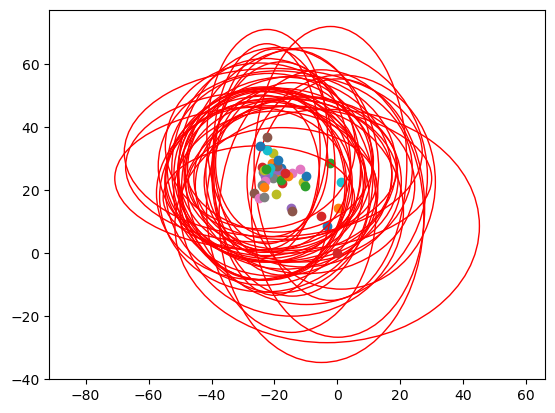

5/5. RFS 89


100%|██████████| 50/50 [00:06<00:00,  7.20it/s]



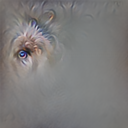
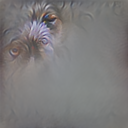
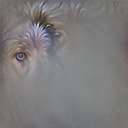
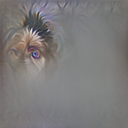
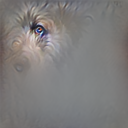

C:\Users\lopez\AppData\Local\Temp\2\ipykernel_19644\179943644.py:149: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  temp_pic = temp_pic.resize((500,500),Image.BILINEAR)
100%|██████████| 50/50 [00:03<00:00, 13.05it/s]



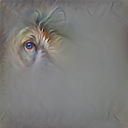
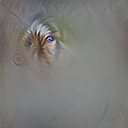
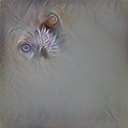
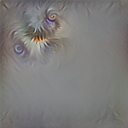
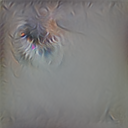

100%|██████████| 50/50 [00:03<00:00, 14.02it/s]



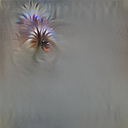
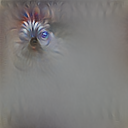
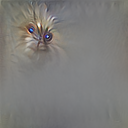
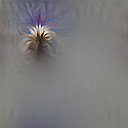
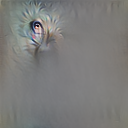

 94%|█████████▍| 47/50 [00:03<00:00, 13.39it/s]


Interrupted optimization at step 48.



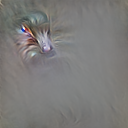
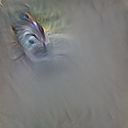
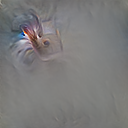
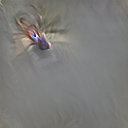
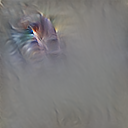

100%|██████████| 50/50 [00:03<00:00, 13.80it/s]



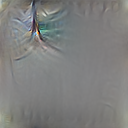
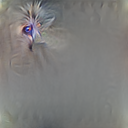
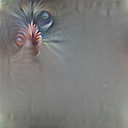
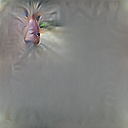
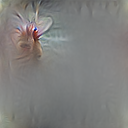

100%|██████████| 50/50 [00:03<00:00, 12.70it/s]



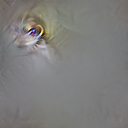
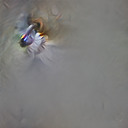
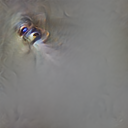
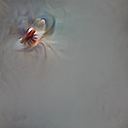
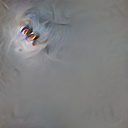

100%|██████████| 50/50 [00:03<00:00, 13.03it/s]



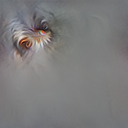
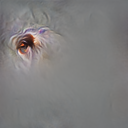
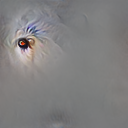
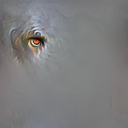
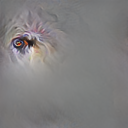

 12%|█▏        | 6/50 [00:00<00:02, 14.67it/s]

In [5]:
import time
time_0 = time.time()
for roi_name in roi_names:
    print('Roi name:  ', roi_name, '\n\n')
    if int(roi_name) < 9: #V1
        layer = 'conv2d2'
    elif int(roi_name) > 12: #IT
        layer = 'mixed4d'
    else: #V4
        layer = 'mixed4a'
    print('1/5.  Start point', int(time.time()-time_0))
    roi_model,n_neurons = load_trained_model(roi_name,layer)
    print('2/5. Loaded', int(time.time()-time_0))
    corrs = compute_val_corrs(roi_name,roi_model)
    print('3/5. Corrd', int(time.time()-time_0))
    goods,all_good_rfs = good_neurons(roi_model,n_neurons,corrs)
    print('4/5. Good neurons', int(time.time()-time_0))
    gaussian_RFs(all_good_rfs,goods,corrs,pixperdeg,stim_size,roi_name,shift_x,shift_y)
    print('5/5. RFS', int(time.time()-time_0))
    generate_MEIS(roi_model,roi_name,goods)
    print('\n\n\n\n\n\n')